# Brain Tumor Classification project

The applications of brain tumour classification can be mainly divided into two categories:
- Classification of brain images into normal and abnormal classes, i.e. whether the brain images contain tumours or not. 
- Classification within abnormal brain images, in other words, discrimination between different types of brain tumours.

We are in the second case here, which is generally a relatively hard and challenging problem compared with binary classification (normal and abnormal). The important of this study is also contain by the fact of some tumors can be benign, there are extrinsic cerebral tumors that do not infiltrate surrounding parenchyma, compare to others, that are malignant, intrinsic cerebral tumors that may cause tumor-infiltrative edema.

Moreover, conventional diagnoses of brain tumor images are made by human interpretation, which heavily relies on the experience of radiologists who review and analyze the characteristics of the images. Consequently, interobserver and intraobserver variability are inevitable. That's why computer-aided diagnosis system can be very interesting to reduce the number of errors and help the diagnostic decision.

This brain tumor dataset containing 3064 images from 233 patients with three kinds of brain tumor: meningioma (708 slices), glioma (1426 slices), and pituitary tumor (930 slices). The original data can be found following this link: [figshare-brain-tumor-detection](https://figshare.com/articles/dataset/brain_tumor_dataset/1512427).

The objective of this project is to build a classifier to classify each type of tumor.

In [1]:
# Imports
import random
import zipfile
import io
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import seaborn as sb

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [6]:
# Constants
IMAGE_SHAPE = (512, 512)

LABELS_NAME = {
    1 : "Meningioma",
    2 : "Glioma",
    3 : "Pituitary"
}

In [8]:
# Functions
def show_image(images: np.array, labels: np.array, border: list, names: dict = LABELS_NAME) -> None:
    """
    This function take the a random image from the 
    the array that contains images, and plot it,
    with as title the class label of the image. Add
    also the border of the tumor.
    """
    # Get a random index
    idx = random.randint(0, len(images))

    # Get the delimitation tumor
    obj = border[idx]

    # Get x and y axis
    x_axis = obj[0, 1::2]
    y_axis = obj[0, ::2]
    
    # Plot a random image
    plt.figure(figsize=(6,6))
    plt.imshow(images[idx], cmap='gray')
    plt.plot(x_axis, y_axis, ls='--', c='y', lw=3)
    plt.title(f"Class: {names[labels[idx]]}")
    plt.axis('off')
    plt.show()

def compare_images(images: np.array, images_recovered: np.array, labels: np.array, names: dict = LABELS_NAME) -> None:
    """
    This function take the a random image from the 
    the array that contains recovered after PCA, 
    and the array that contains images, reshape it
    and plot both with as title the class label of 
    the images.
    """
    # Get a random index
    idx = random.randint(0, len(images))

    # Plot
    plt.figure(figsize=(12,12))
    plt.subplot(1, 2, 1)
    plt.imshow(images[idx, :].reshape(IMAGE_SHAPE), cmap='gray')
    plt.title(f"Original \n Class: {names[labels[idx]]}")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(images_recovered[idx, :].reshape(IMAGE_SHAPE), cmap='gray')
    plt.title(f"Compressed \n Class: {names[labels[idx]]}")
    plt.axis('off')
    plt.show()                                                                                                

def predict_image(images: np.array, labels: np.array, prediction: np.array) -> None:
    """
    This function take the a random image from the 
    the array that contains test images, reshape it 
    and plot it, with as title the predicted value 
    of the image.
    """
    # Get a random index
    idx = random.randint(0, len(images))
                   
    # Plot a random image
    plt.figure(figsize=(6,6))
    plt.imshow(images[idx],  cmap='gray')
    plt.title(f"True class: {labels[idx]} \n Predicted class: {prediction[idx]}")
    plt.axis('off')
    plt.show()

### Data loading

Now we need to read the data store in the zip files. Note that I use the data storage of the zip files, i.e. the 4 zip files need to be stored in a folder named `data` at the same level than the notebook.

Each zip file contains .mat file format, which can be relatively complex to extract with Python. So we use the `h5py` library. Each file stores a struct containing the following fields for an image:
- cjdata.label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor
- cjdata.PID: patient ID
- cjdata.image: image data
- cjdata.tumorBorder: a vector storing the coordinates of discrete points on tumor border.
- cjdata.tumorMask: a binary image with 1s indicating tumor region

For the tumorBorder, it is for example, [x1, y1, x2, y2,...] in which x1, y1 are planar coordinates on tumor border. It was generated by manually delineating the tumor border. So we can use it to generate binary image of tumor mask.

In this notebook, we will only use the label, image and tumorBorder (for EDA). The objective with the cell below, is to load the data and store it into python list. Also, the large majority of the images have a 512x512 format, but it is not always the case, so with resize the images with different size to this standard size.

In [10]:
# Define a list to store the image, label, and border arrays 
image_list, label_list, border_list  = [[] for _ in range(3)]
# Define the list of zip files
zip_folders = [folder for folder in os.listdir('./data/') if folder.endswith('.zip')]

for folder in zip_folders: 
    # Read zip file (without unzip it)
    with zipfile.ZipFile(os.path.join('data', folder), 'r') as zip_ref:
        # Get the list of .mat file in the zip folder
        mat_files = zip_ref.namelist()

        # Get the number of images
        num_files = len(mat_files)
        
        # Make a for loop
        for image in mat_files:
            # Open the first file in the zip folder
            with zip_ref.open(image) as image_bytes:
                
                # Load the .mat file using h5py
                with h5py.File(io.BytesIO(image_bytes.read()), 'r') as image_h5:
                    
                    # Get a dictionary of all the data in the file structure
                    data = image_h5['cjdata']

                    # Get the image, label and border and save in h5 object
                    data_img = data['image']
                    data_label = data['label']
                    data_broder = data['tumorBorder']

                    # Store h5 content in numpy arrays
                    img = np.array(data_img[:], dtype=np.uint8)
                    label = np.array(data_label[:], dtype=np.uint8)
                    border = np.array(data_broder[:], dtype=np.float32)

                    # Resize the img to a standard size
                    img_resized = cv2.resize(img, IMAGE_SHAPE)

                    # Append arrays to storage list
                    image_list.append(img_resized)
                    label_list.append(label)
                    border_list.append(border)

# Assertion on list length
assert len(image_list) == len(label_list) == len(border_list)

Now we have the data store in lists, we can create numpy array for images and labels, which is the convenient format to use machine learning algorithm from Scikit-Learn.

In [5]:
# Concatenate the list of images into a single numpy array
images = np.stack(image_list)
# Convert the labels list to a numpy array
labels = np.array(label_list).reshape(-1)

print(f"Image shape: {images.shape}")
print(f"Label shape: {labels.shape}")

Image shape: (3064, 512, 512)
Label shape: (3064,)


As we want to use a classical machine learning algorithm and avoid the deep learning method because we might have too few samples, we have to flatten the images. Indeed, machine learning algorithms cannot understand images, they work with tabular data.

In [6]:
# Create X and y array to use classical ML algorithm
# Flatten the data first
X = images.reshape(len(images), -1)
y = labels.copy() # Shallow copy (not an issue here)

print(f"Flatten array shape: {X.shape}")

Flatten array shape: (3064, 262144)


### Eploratory Data Analysis

As we are working with image data, there is not much EDA to do. First, we can look at random images to see what they look like using the `show_images` function defined earlier. Note that this function takes also the edge of the tumour as input to simplify the identification of the tumour location.

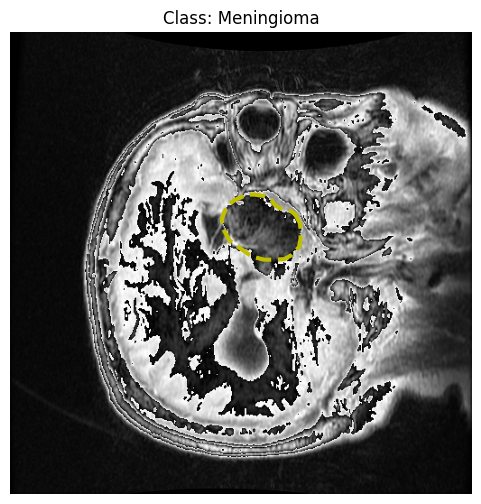

In [9]:
# Plot an image
show_image(images, labels, border_list)

We can see that not all images have the same zoom, and that images have different rotations. This brings variety to the data set, and is a good thing if we want a model that generalize well.

We can also check the number of images per class, to see if the data set is imbalance or not.

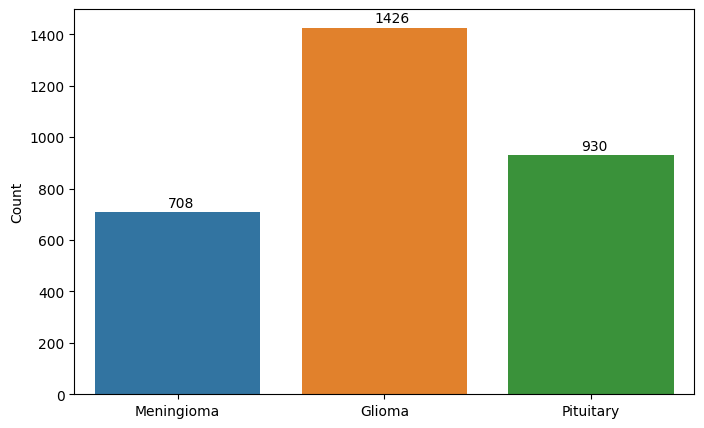

In [10]:
# Repartition of the classes across the dataset
_, counts = np.unique(y, return_counts=True)

# Plot classes counts
plt.figure(figsize=(8, 5))
sb.barplot(x=list(LABELS_NAME.values()), y=counts)
for i, j in enumerate(counts):
    plt.text(i-0.05, j+20, str(j))
plt.ylabel('Count')
plt.show()

We can see that we have an imbalanced data set. We have twice more Glioma (malignant tumors) than Meningioma (benign tumors). But there is not large contrast between classes, so we won't use method like oversampling to rebalanced our data set.

In [11]:
# Verification of pixel gray scale
print(f"Maximum pixel value: {X.max()}")
print(f"Minimum pixel value: {X.min()}")

Maximum pixel value: 255
Minimum pixel value: 0


We can also use TSNE technique to examine our data in a low dimensional space. TSNE for T-distributed Stochastic Neighbor Embedding is a dimensionality reduction technique. It reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. 

It create probability distribution that represent similarities between neighbors in the high dimensional space, and create low dimensional space with the same number of points as the original space. The goal of this algorithm is to find similar probability distribution in low dimensional space using Student t-distribution than in the high dimensional space.

It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space, like our dataset.

In [63]:
# Invoking the TSNE method
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

Note that we only plot 500 random points to get a clear graph.

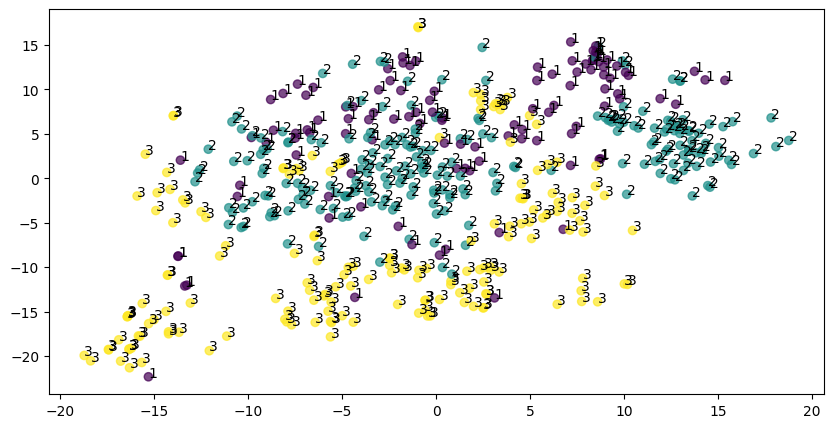

In [29]:
# Generate random sequence
rand_seq = random.sample(range(len(X)), 500)

# Plot the result of TSNE reduction
plt.figure(figsize=(10,5))
plt.scatter(X_tsne[rand_seq, 0], X_tsne[rand_seq, 1], c=y[rand_seq], alpha=0.7)
for i in rand_seq:
    plt.text(X_tsne[i, 0], X_tsne[i, 1], str(y[i]))
plt.show()

We can see that there is some overlap between the groups, especially between group 1 (meningioma) and group 2 (glioma). However, it seems possible to differentiate the classes in this problem.

The next step is preprocessing, which is essential before training a machine learning algorithm.

### Preprocessing

In this section we will prepare our data to improve our results with the machine learning algorithm. Since we have a dataset with a high dimensional space and only a few samples, we will use dimensionality reduction methods. 

Before proceeding, we will normalise our data, which will allow us to run the different algorithms faster and ensure greater accuracy. As each pixel is between 0 and 255, we can simply divide all the arrays by 255.

And we will artificially create a train and test set. The test set will contain 20% of the original data, with the same class proportion using the `stratify` argument from the `train_test_split` method.

In [7]:
# Normalization
X = (X / 255.0).astype(np.float16)

# Split into train and test set
X_train, X_test, y_train , y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

# Check train an test size
print(f"Training size: {len(y_train)}")
print(f"Testing size: {len(y_test)}")

Training size: 2451
Testing size: 613


As we said before, since we have a data set with a very high dimensional space (262 144 features), it is very important to reduce its dimensionality. Indeed, a high dimensional space like this one can lead to overfitting, especially if we have few observations as in our case.

To reduce the dimensionality, we will therefore use principal component analysis (PCA), which identifies the hyperplane closest to the data, and then projects the data onto this hyperplane. The hyperplane chosen is the one that preserves the maximum variance in the data.

To choose the right number of dimensions, we can use the elbow method or choose the number of dimensions that represent a sufficiently large proportion of the variance (e.g., 95%). We will continue to use the second option because we want to compress our images without losing too much information. But we will plot the ratio of variance explained versus the number of components to visualise our result.

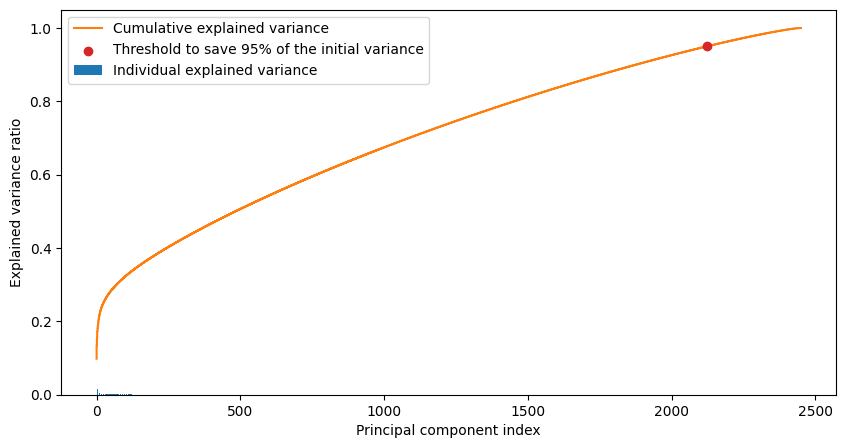

In [26]:
# Dimensionality reduction using PCA
# Detection of the number of component needed
pca = PCA()
pca.fit(X_train)

# Explained variance ratio analysis
exp_var = pca.explained_variance_ratio_
cumsum_exp_var = np.cumsum(exp_var)
n_components = len(exp_var) # Because n_components = min(n_samples, n_features)

# Plot only the 500 first components
plt.figure(figsize=(10,5))
plt.bar(
    range(0, n_components), 
    exp_var, 
    label='Individual explained variance', 
    color='C0'
)
plt.step(
    range(0, n_components), 
    cumsum_exp_var, 
    label='Cumulative explained variance', 
    color='C1'
)
plt.scatter(
    np.argmax(np.cumsum(exp_var) >= 0.95), 
    0.95, 
    label='Threshold to save 95% of the initial variance', 
    c='C3',
    zorder=3
)
plt.xlabel("Principal component index")
plt.ylabel("Explained variance ratio")
plt.legend()
plt.show()

We can see that with roughly 2048 components, we preserve almost 95% of the variance. So we set the PCA algorithm with this parameter, and after fitting the model, we can reduce the train and the test sets.

In [27]:
# Define and train PCA with 2048 components (preserved ~95% of the variance)
pca = PCA(n_components=2048, random_state=123)
pca.fit(X_train)

# Transform our train and test data
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

By performing the reverse transformation, we can retrieve our image after it has been compressed, and look at the differences between the original image and the compressed image with the `compare_images` function defined earlier.

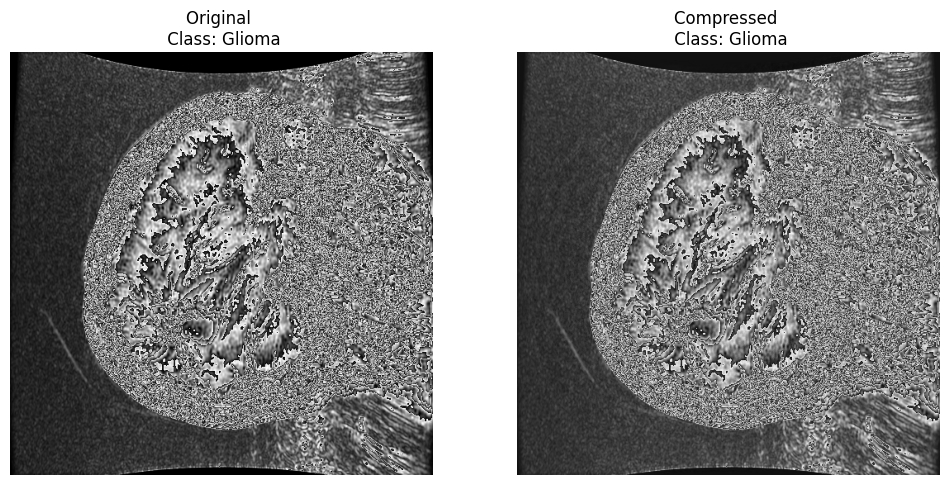

In [28]:
# Get compressed array
X_train_recovered = pca.inverse_transform(X_train_reduced)

compare_images(X_train, X_train_recovered, y_train)

We can see that the reduction of the PCA loses almost no information. This is very good, because we go from 262 144 features to 2048! This will greatly help our machine learning algorithm to process our data.

As this preprocessing is time consuming, we save the reduced data (train and test set) in a compressed numpy array format. This will allow us to retrieve our results without having to run this section again.

In [29]:
# Save X arrays in npz compressed format
np.savez_compressed('./CompressedArray', train=X_train_reduced, test=X_test_reduced)

We can load the arrays with the following cell:

In [8]:
# Load the compressed X arrays
loaded = np.load('./CompressedArray.npz')
for i, file in enumerate(loaded.files, start=1):
    print(f"File n°{i}: {file}")

# Assign X train and test
X_train_reduced = loaded['train']
X_test_reduced = loaded['test']

File n°1: train
File n°2: test


Furthermore, we have an imbalanced dataset and in order to use cross validation, we will use stratified cross validation. Stratified cross validation (or StratifiedKFold) is a variation of the base cross validation technique available in sklearn (KFold), which return stratified fold: each set contains approximately the same percentage of samples of each target class as the complete set. 

So StratifiedKFold keeps the class proportions the same across all of the folds, which is vital for maintaining a representative subset of our data set.

In [9]:
# Define the StratifiedKFold
skf = StratifiedKFold(n_splits=5)

We can visualize the different folds on each class of our data. To do that, we have to sort the data by class, since it is shuffle (for a better visualization).


The `split` method from `StratifiedKFold` class generate indices to split data into training and test set. We can use this indices to create a figure.

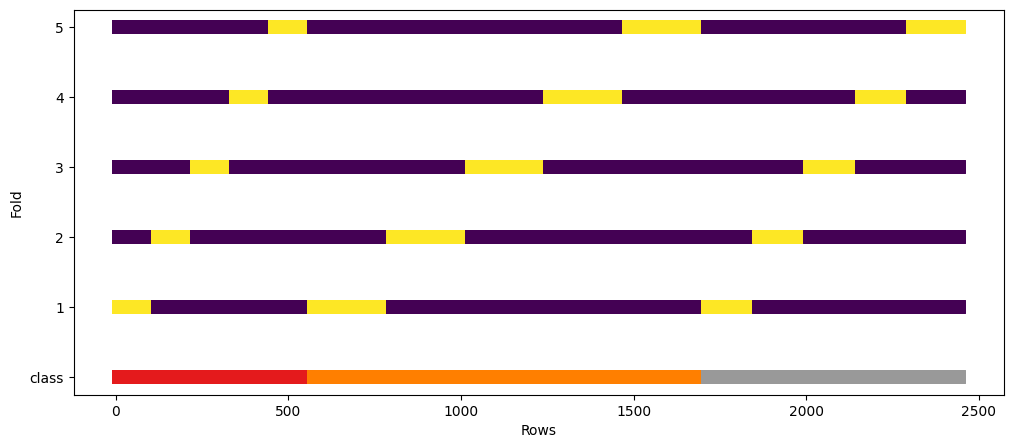

In [37]:
# Visualize the Stratified cross validation
# Sort indices by class
sorted_indices = np.argsort(y_train)

# Sort y_train and X_train by class
y_train_sorted = y_train[sorted_indices]
X_train_sorted = X_train_reduced[sorted_indices]

# Plot
plt.figure(figsize=(12, 5))
for i, (tr_idx, te_idx) in enumerate(skf.split(X_train_sorted, y_train_sorted), start=1):
    # Fill in indices with the training/test groups
    indices = np.zeros(len(X_train_sorted))
    indices[te_idx] = 1 
    
    plt.scatter(
        range(len(indices)), 
        [i] * len(indices),
        c=indices,
        marker="_",
        lw=10
    )
plt.scatter(
    range(len(indices)),
    [0] * len(indices), 
    c=y_train_sorted,
    marker="_", 
    lw=10,
    cmap='Set1'
)
plt.ylabel('Fold')
plt.xlabel('Rows')
# Change the yticks to add class
plt.yticks(ticks=range(6), labels=['class'] + list(range(1,6)))
plt.show()

We can see that for each class, there is 5 folds used as validation set. It keeps the class proportions the same across all of the folds, which is vital for maintaining a representative subset of our data set as said before.

It is important to maintain a representative subset of our data set during the training, inp particular to avoid overfitting.

### Modeling

In this section, we will use two different machine learning algorithm to classify our images, analyze their performance, optimize them and choose the best one. Note that we need to use algorithm that supports multilabel classification (since we have 3 classes).

The first classifier is K Nearest Neighbors (KNN). The idea behind KNN is very simple, for each record to be classified, it finds K records that have similar features (using a distance metric), and it finds out what the majority class is among those similar records and assign that class to the new records.

The second classifier is Support Vector Machine (SVM). SVM is a more complex algorithm, but very powerful and capable of performing linear and non linear classification. The main idea behind SVM is to move the data in a higher dimension and find a support vector classifier that separates the higher dimensional data into the different groups using a kernel function to systematically find the classifier.

In [10]:
# Initialize classifier algorithms
knn = KNeighborsClassifier()
svc = SVC()

First, we can observe the results of KNN and SVM using (stratified) cross-validation without passing any parameters to the algorithms.

In [39]:
# Use stratified cross validation on KNN classifier
result_knn = pd.DataFrame(cross_validate(
    knn,
    X_train_reduced,
    y_train,
    return_train_score=True,
    cv=skf.split(X_train_reduced, y_train),
    scoring=['accuracy']
))

# Get mean train and test accuracy
print(f"Mean train accuracy: {result_knn['train_accuracy'].mean():.3f}")
print(f"Mean validation accuracy: {result_knn['test_accuracy'].mean():.3f}")

Mean train accuracy: 0.680
Mean validation accuracy: 0.630


In [135]:
# Use stratified cross validation on SVM classifier
result_svc = pd.DataFrame(cross_validate(
    svc,
    X_train_reduced,
    y_train,
    return_train_score=True,
    cv=skf.split(X_train_reduced, y_train),
    scoring=['accuracy']
))

# Get mean train and test accuracy
print(f"Mean train accuracy: {result_svc['train_accuracy'].mean():.3f}")
print(f"Mean validation accuracy: {result_svc['test_accuracy'].mean():.3f}")

Mean train accuracy: 0.990
Mean validation accuracy: 0.865


We can see that the SVM performs better, but it is also overfitted, whereas the KNN is not. Moreover, we can improve the result of KNN by adjusting the hyperparameters. And we can try to reduce the overfitting of the SVM by the same procedure.

We can also look at the result using a graph with box plot for each fold result.

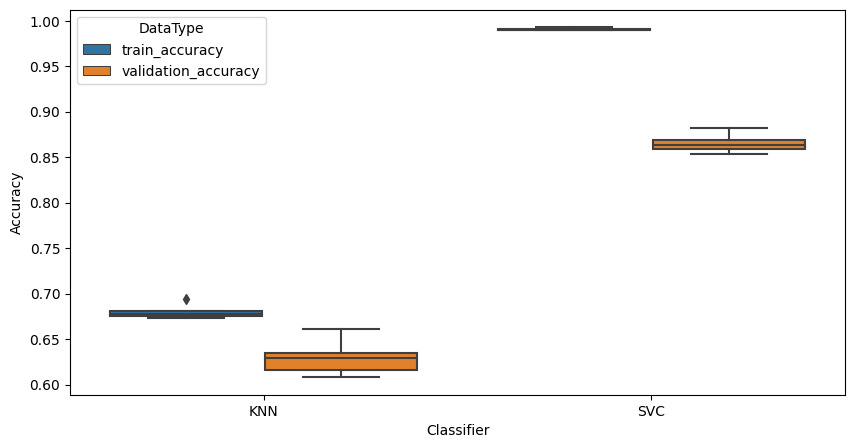

In [140]:
# Comparison of result
# Create a dataframe by concatenating results
result = pd.concat([result_knn, result_svc])

# Add classifiers columns
result['Classifier'] = ["KNN"]*5 + ["SVC"]*5
# Rename validation score
result.rename(columns={'test_accuracy' : 'validation_accuracy'}, inplace=True)

# Melt the dataframe
result = pd.melt(
    result, 
    id_vars=['Classifier'], 
    value_vars=['train_accuracy', 'validation_accuracy'], 
    var_name='DataType', 
    value_name='Accuracy'
)

# Plot the result
plt.figure(figsize=(10, 5))
sb.boxplot(data=result, x='Classifier', y='Accuracy', hue='DataType')
plt.show()

We clearly see the overfitting of the SVM classifier, but also the slightly low score of the KNN.

The next step is to optimize model hyperparameters. To do that we can use `GridSearchCV` class from Scikit-Learn which is an exhaustive search over specified parameter values for an estimator.

The following cell return the best average validation score and the parameters that lead to this score.

In [11]:
# Define a dictionary of parameters choice for optimization
params = {
    'C': [0.01, 0.1, 1., 10., 100., 1000.],
    'kernel': ["rbf", "sigmoid"]
}

# Invoking the GridSearchCV method
grid_search_svc = GridSearchCV(
    svc, 
    param_grid=params, 
    cv=skf.split(X_train_reduced, y_train),
    return_train_score=True
)
grid_search_svc.fit(X_train_reduced, y_train)

# Display best score and best parameters
print(f"Best score : {grid_search_svc.best_score_:.3f}")
print(f"Best parameters : {grid_search_svc.best_params_}")

Best score : 0.878
Best parameters : {'C': 10.0, 'kernel': 'rbf'}


We can see an improvement, we reduce the error rate by almost 10% (from about 13.5% to about 12.2%)! Using a l2 regularization parameter, named C, equal to 10 and a RBF (Radial Basis Function) kernel.

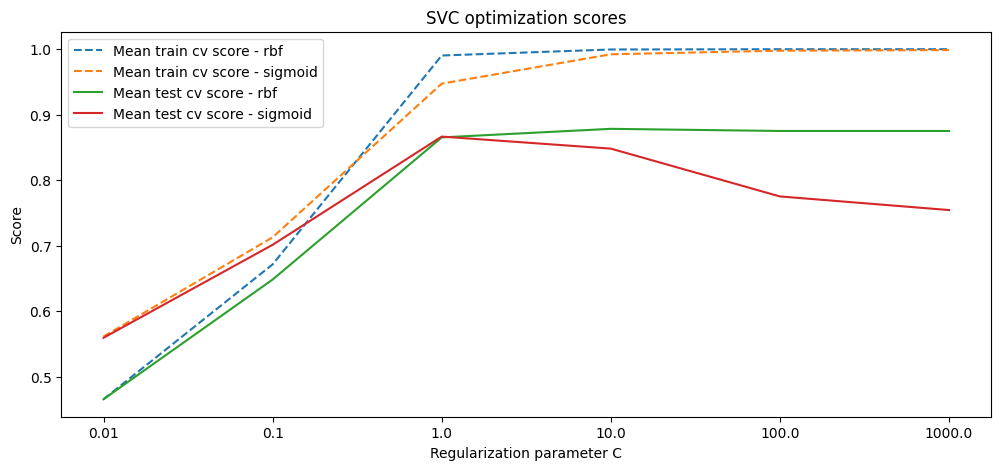

In [12]:
# Create a dataframe with the result of grid search
df_svc = pd.DataFrame(grid_search_svc.cv_results_)

# Pivot the dataframe to simplify plot
df_svc = df_svc.pivot(
    columns='param_kernel',
    index='param_C',
    values=['mean_train_score', 'mean_test_score']
)

# Change index type to str to plot x axis
df_svc.index = df_svc.index.astype(str)

# Plot train and validation scores
plt.figure(figsize=(12, 5))
plt.plot(
    df_svc.index, 
    df_svc['mean_train_score']['rbf'],
    label="Mean train cv score - rbf",
    ls='--'
)
plt.plot(
    df_svc.index, 
    df_svc['mean_train_score']['sigmoid'],
    label="Mean train cv score - sigmoid",
    ls='--'
)
plt.plot(
    df_svc.index, 
    df_svc['mean_test_score']['rbf'],
    label="Mean test cv score - rbf"
)
plt.plot(
    df_svc.index, 
    df_svc['mean_test_score']['sigmoid'],
    label="Mean test cv score - sigmoid"
)
plt.xlabel("Regularization parameter C")
plt.ylabel("Score")
plt.title("SVC optimization scores")
plt.legend()
plt.show()

But when we look at the curve for the train (dashed) and validation score, we can see that we still overfitting. Since the train score is close to 1, the gap between the train and validation is too large. 

Nevertheless, the model using parameter C equal to 1, and a sigmoid kernel seems to have almost same result of the validation, but less overfitting. It can be an option for us.

We can use the same procedure to improve the result of the KNN.

In [14]:
# Define a dictionary of parameters choice for optimization
params = {
    'n_neighbors': np.arange(3, 10),
    'metric': ["minkowski", "cosine"]
}

# Invoking the GridSearchCV method
grid_search_knn = GridSearchCV(
    knn, 
    param_grid=params, 
    cv=skf.split(X_train_reduced, y_train),
    return_train_score=True
)
grid_search_knn.fit(X_train_reduced, y_train)

# Display best score and best parameters
print(f"Best score : {grid_search_knn.best_score_:.3f}")
print(f"Best parameters : {grid_search_knn.best_params_}")

Best score : 0.858
Best parameters : {'metric': 'cosine', 'n_neighbors': 4}


We can see a big improvement, we reduce the error rate by almost 60% (from about 37% to about 14.2%)! Using 4 neighbors to classify a new point and cosine distance metric as a measure of similarity. 

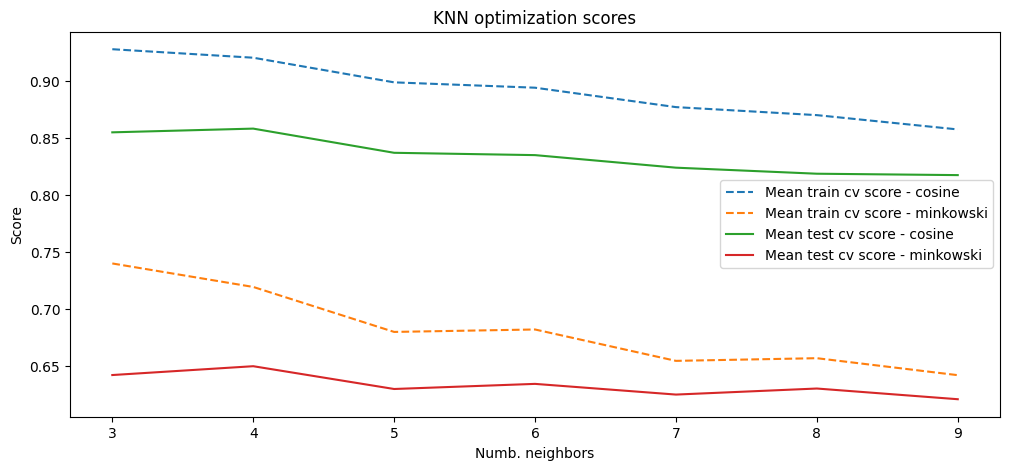

In [15]:
# Create a dataframe with the result of grid search
df_knn = pd.DataFrame(grid_search_knn.cv_results_)

# Pivot the dataframe to simplify plot
df_knn = df_knn.pivot(
    columns='param_metric',
    index='param_n_neighbors',
    values=['mean_train_score', 'mean_test_score']
)

# Plot train and validation scores
plt.figure(figsize=(12, 5))
plt.plot(
    df_knn.index, 
    df_knn['mean_train_score']['cosine'],
    label="Mean train cv score - cosine",
    ls='--'
)
plt.plot(
    df_knn.index, 
    df_knn['mean_train_score']['minkowski'],
    label="Mean train cv score - minkowski",
    ls='--'
)
plt.plot(
    df_knn.index, 
    df_knn['mean_test_score']['cosine'],
    label="Mean test cv score - cosine"
)
plt.plot(
    df_knn.index, 
    df_knn['mean_test_score']['minkowski'],
    label="Mean test cv score - minkowski"
)
plt.xlabel("Numb. neighbors")
plt.ylabel("Score")
plt.title("KNN optimization scores")
plt.legend()
plt.show()

Moreover we can see that in addition of the good result of the KNN, we are not overfitting here. It seems that the KNN is a better choice as classifier for brain tumor classification.

We can define our model using the best result of the hyperparameter search for the KNN, fit the model using all the train set, and predict the result of test set. Finally we display the accuracy score on the test set.

In [38]:
# Define the model with the best estimator
model = grid_search_knn.best_estimator_

# Pipeline prediction
model.fit(X_train_reduced, y_train)
y_pred = model.predict(X_test_reduced)

print(f"Accuracy on test set: {accuracy_score(y_test, y_pred):.3f}")

Accuracy on test set: 0.876


We can see that we have an accuracy about 87.6%, which is very good for classical machine learning algorithm working on images. We can also observe the classification reports to have metrics for each class.

In [42]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.82      0.73      0.77       142
           2       0.87      0.90      0.88       285
           3       0.93      0.95      0.94       186

    accuracy                           0.88       613
   macro avg       0.87      0.86      0.87       613
weighted avg       0.87      0.88      0.87       613



The result are slightly better on the class 3 (pituitary tumor), than the others. And we can see that the recall of the first class (meningioma) is quiet low compared to the others.

We can also use a confusion matrix to see the number of good prediction for each class.

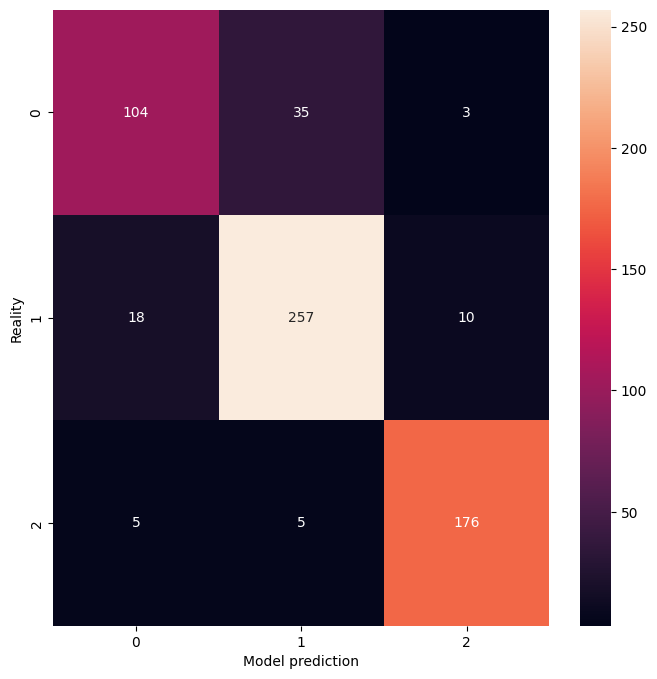

In [62]:
# Confusion matrix
plt.figure(figsize=(8,8))
sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt = 'g')
plt.xlabel("Model prediction")
plt.ylabel("Reality")
plt.show()

### Conclusion

To conclude, we have seen that the classification of images such as MRI on brain tumours is a complex task. It requires preprocessing before the use of a machine learning algorithm. Indeed, because of the high resolution of the images (512x512), and because the machine learning algorithm only allows tabulate data, the data set ends up with a very high dimensional space. The application of a dimensionality reduction method such as PCA is therefore mandatory, in particular to avoid overfitting.

Next, we saw that we could obtain good results using both SVM and KNN algorithms, but we finally chose KNN because it is less likely to overfit the data and generalizes better. After optimising some hyperparameters, we achieved an accuracy of about 86.7% on the test set!

But for health research, this might not be enough. It is therefore possible to use more advanced techniques such as convolutional neural networks (CNN).